<a href="https://colab.research.google.com/github/rainforest01-coder/ESAA_files/blob/main/ESAA_WEEK06_2%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07 LightGBM

LightGBM은 XGBoost와 함께 부스팅 계열 알고리즘에서 각광
* 장점
> XGBoost보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량도 상대적으로 적음, 카테고리형 피처의 자동 변환과 최적 분할(원핫인코딩 등을 사용하지 않고도 변환)

* 단점
> 10000건 이하의 적은 데이터 세트에 적용할 경우 과적합 발생 가능

리프 중심 트리 분할 방식 사용: 트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하여 비대칭적인 규칙 트리 생성

In [ ]:
!pip install scikit-learn==1.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 43.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Operation cancelled by user


In [ ]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.5
    Uninstalling xgboost-3.0.5:
      Successfully uninstalled xgboost-3.0.5


In [3]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0


In [ ]:
!pip install numpy==1.26.4

In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

### LightGBM 하이퍼 파라미터

하이퍼파라미터는 XGBoost와 비슷하나 트리의 깊이가 더 깊어지므로 이에 맞는 설정 필요

* num_iterations: 디폴트 100/반복 수행하려는 트리의 개수 지정/ 사이킷런 호환에서는 n_estimators
* learning_rate: 디폴트 0.1
* max_depth: 디폴트 -1/0보다 작은 값 지정 시 깊이 제한없음
* min_data_in_leaf:디폴트 20/결정트리의 min_samples_leaf와 같은 파라미터/사이킷런 래퍼에서는 min_child_samples파리미터로 이름 변경/최종 결정 클래스인 리프노드가 되기 위해 최소한으로 필요한 레코드 수
* num_leaves: 디폴트 31/하나의 트리가 가질 수 있는 최대 리프 개수
* boosting:디폴트 gbdt/부스팅의 트리를 생성하는 알고리즘/rf:랜덤 포레스트
* bagging_fraction:디폴트 1.0/트리가 커져서 과적합되는 것을 제어/ 데이터를 샘플링하는 비율을 지정/사이킷런 래퍼에서는 subsample로 동일하게 파라미터 이름이 변경
* feature_fraction:디폴트 1/ 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율
* lambdaJ2 :디폴트 0/ L2 regulation 제어를 위한 값/피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과/LightGBMCIassifier에서는 regjambda로
* Iambda_l1 ：디폴트 0/ L1 regulation 제어/LightGBMCIassifier에서는 reg_alpha로

learning task 파라미터
* objective: 최솟값을 가져야 할 손실함수 정의/유형에 따라 다른 손실함수 지정

###하이퍼 파라미터 튜닝 방안

* num_leaves의 개수를 중심으로 min_child_samples,max_depth를 함꼐 조정하여 모델의 복잡도를 줄임
* learning_rate를 작게 하면서 n_estimators를 크게 하는 것
* reg_lambda,reg_alpha 등의 규제 적용

###파이썬 래퍼LIghtGBM, 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
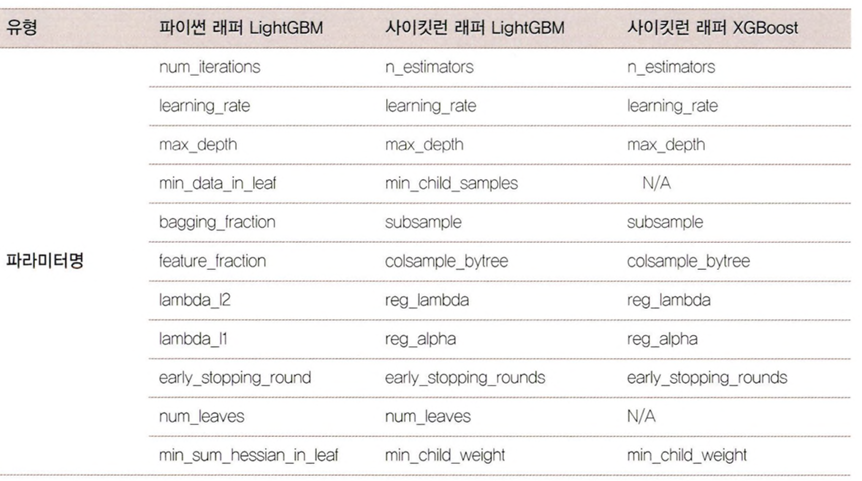

###LightGBM적용-위스콘신 유방암 예측

In [5]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
dataset=load_breast_cancer()
cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)

cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

lgbm_wrapper=LGBMClassifier(n_estimators=400,learning_rate=0.05)
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_wrapper.fit(
    X_tr, y_tr,
    eval_set=evals,
    eval_metric="logloss",
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(10)
    ]
)

preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test,preds,pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9465


파이썬패키지도 피처 중요도를 시각화할 수 있는 내장 API제공
plot_importance()인데 이때 사이킷런 래퍼 클래스를 입력해도 시각화 제공

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

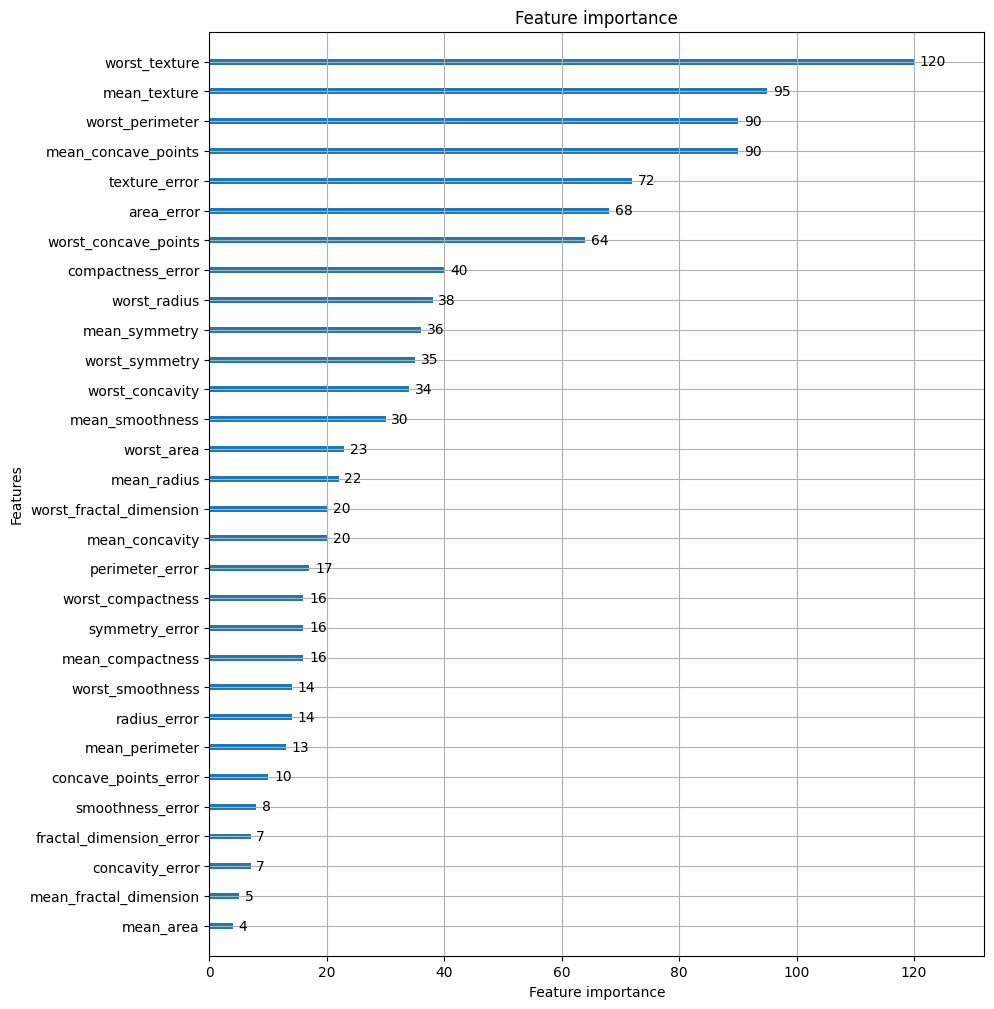

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

##08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

GridSearch방식은 너무 오래걸림

###베이지안 최적화 개요
목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식

새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만들어냄

대체모델은 획득함수로부터 최적 함수를 예측할 수 있는 입력값을 추천 받은 뒤 이를 기반으로 죄적 함수 모델을 개선해 나가고 획득함수는 개선된 대체 모델을 기반으로 최적 입력값 계산

1. 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과 관측
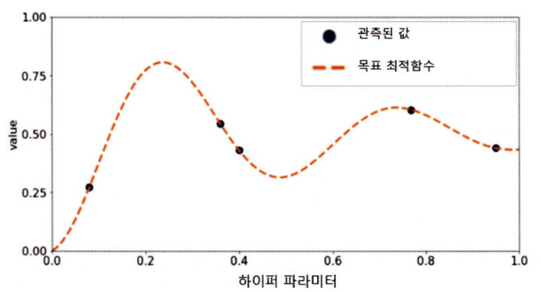
2. 관측된 값을 기반으로 대체모델은 최적함수를 추정/최적 관측값: 가장 높은 y값을 가질 때의 하이퍼 파라미터
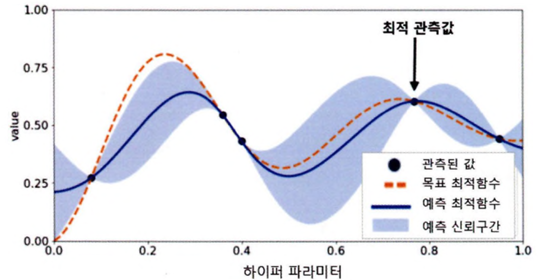

3. 추정된 최적함수를 기반으로 획득함수는 다음으로 관측할 하이퍼 파라미터 값을 계산/ 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달
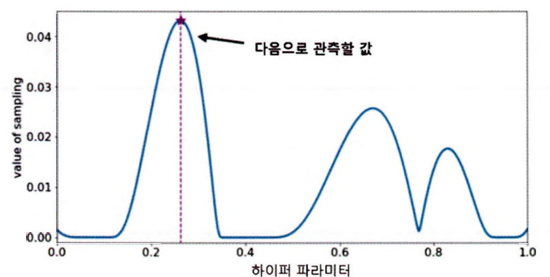

4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체모델은 갱신되어 다시 최적 함수 예측 추정
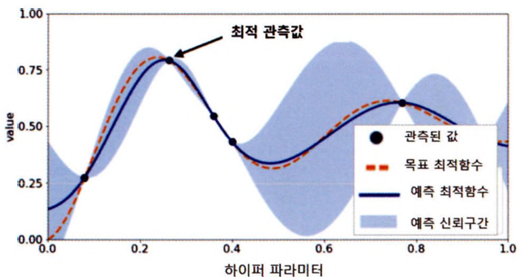

5. 3,4번을 특정 횟수만큼 반복하게 되면 대체 모델의 불확실성이 개선되고 점차 정확한 최적 함수 추정이 가능

###HyperOpt사용하기

베이지안 최적화를 머신러닝 모델의 하이퍼 파라미터 튜닝에 적용할 수 있게 제공되는 여러 파이썬 패
키지들이 있는데 대표적으로는 HyperOpt, Bayesian Optimization, Optuna 등

In [ ]:
!pip install hyperopt

주요 로직
1. 입력 변수명과 입력값의 검색 공간 설정
2. 목적함수 설정
3. 목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추

1. HyperOpt hp모듈을 이용하여 입력 변수명과 입력값의 검색공간 설정
변수명과 입력값 검색 공간은 파이썬 딕셔너리 형태로 설정되어야함

In [1]:
from hyperopt import hp
search_space={'x': hp.quniform('x',-10,10,1),'y':hp.quniform('y',-15,15,1)}

입력값의 검색 공간을 제공하는 대표적인 함수

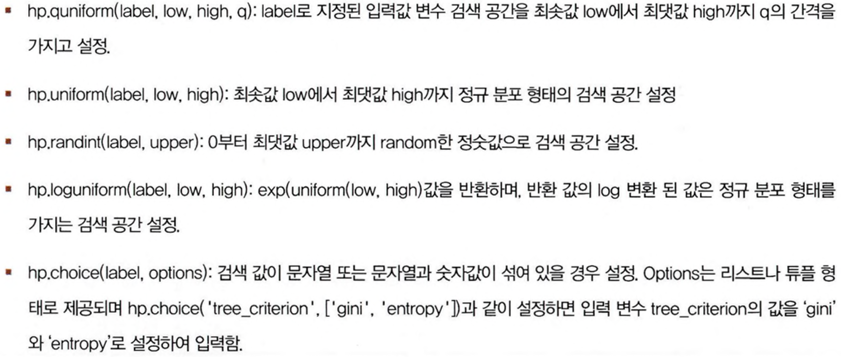

2. 목적함수 생성

목적함수는 반드시 변숫값과 검색공간을 가지는 딕셔너리를 인자로 받고 특정 값을 반환하는 구조로 만들어야함/숫자형 단일값 외에도 딕셔너리 형태로 반환 가능하나 loss,status키 값을 설정하여 반환해야함

In [2]:
from hyperopt import STATUS_OK
def objective_func(search_space):
  x=search_space['x']
  y=search_space['y']
  retval=x**2-20*y
  return retval

3. 목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아 줘야함
fmin(objective,space,algo,max_evals,trials)함수 사용
주요 인자:  
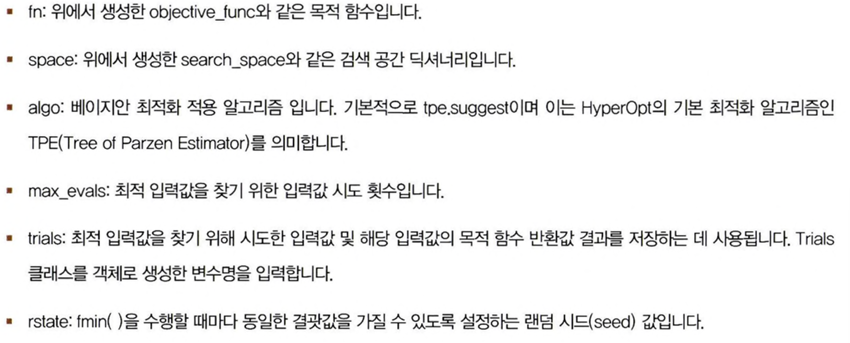

rstate는 책이랑 동일하게 하려고 사용하고 일반적으로는 잘 사용X
최솟값일수록 최적 관측값

In [12]:
from hyperopt import fmin,tpe,Trials
import numpy as np

#입력 결괏값을 저장한 Trial객체값 생성
trial_val=Trials()
best_01=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=5,
             trials=trial_val)
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 133.74trial/s, best loss: -300.0]
best: {'x': np.float64(-0.0), 'y': np.float64(15.0)}


In [15]:
#20번 수행
trial_val=Trials()
best_02=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=20,
             trials=trial_val)
print('best:',best_02)

100%|██████████| 20/20 [00:00<00:00, 472.19trial/s, best loss: -216.0]
best: {'x': np.float64(8.0), 'y': np.float64(14.0)}


In [17]:
#fmin()에 인자로 들어가는 Trials 객체의 result속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss'：함수 반환값, ‘status'：반환 상태값}
print(trial_val.results)

[{'loss': 45.0, 'status': 'ok'}, {'loss': 81.0, 'status': 'ok'}, {'loss': -156.0, 'status': 'ok'}, {'loss': -176.0, 'status': 'ok'}, {'loss': -104.0, 'status': 'ok'}, {'loss': 129.0, 'status': 'ok'}, {'loss': -96.0, 'status': 'ok'}, {'loss': -216.0, 'status': 'ok'}, {'loss': -4.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 84.0, 'status': 'ok'}, {'loss': -196.0, 'status': 'ok'}, {'loss': -20.0, 'status': 'ok'}, {'loss': -4.0, 'status': 'ok'}, {'loss': 316.0, 'status': 'ok'}, {'loss': 36.0, 'status': 'ok'}, {'loss': -71.0, 'status': 'ok'}, {'loss': -4.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': 256.0, 'status': 'ok'}]


In [18]:
#Trials객체의 vals속성에 {입력변수명: 개별 수행 시마다 입력된 값 리스트}
print(trial_val.vals)

{'x': [np.float64(5.0), np.float64(-9.0), np.float64(8.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-2.0), np.float64(8.0), np.float64(6.0), np.float64(-1.0), np.float64(-2.0), np.float64(8.0), np.float64(10.0), np.float64(-4.0), np.float64(6.0), np.float64(4.0), np.float64(3.0), np.float64(-6.0), np.float64(9.0), np.float64(6.0)], 'y': [np.float64(-1.0), np.float64(0.0), np.float64(11.0), np.float64(9.0), np.float64(6.0), np.float64(-4.0), np.float64(5.0), np.float64(14.0), np.float64(2.0), np.float64(2.0), np.float64(-4.0), np.float64(13.0), np.float64(6.0), np.float64(1.0), np.float64(-14.0), np.float64(-1.0), np.float64(4.0), np.float64(2.0), np.float64(1.0), np.float64(-11.0)]}


results와 vals 속성값들을 DataFrame으로 만들어
좀 더 직관적으로 확인

In [19]:
import pandas as pd

losses=[loss_dict['loss'] for loss_dict in trial_val.results]

result_df=pd.DataFrame({'x':trial_val.vals['x'],'y':trial_val.vals['y'],'losses':losses})
result_df

,x,y,losses
0,5.0,-1.0,45.0
1,-9.0,0.0,81.0
2,8.0,11.0,-156.0
3,-2.0,9.0,-176.0
4,-4.0,6.0,-104.0
5,7.0,-4.0,129.0
6,-2.0,5.0,-96.0
7,8.0,14.0,-216.0
8,6.0,2.0,-4.0
9,-1.0,2.0,-39.0


###HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

적용해야 할 하이퍼 파라미터와 검색 공간을 설정하고 목적 함수에서 XGBoost를 학습 후에 예측 성능 결과를 반환 값으로 설정. fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용하여 최적의 예측 성능 결과를 반환하는 최적 입력값 결정

**주의**
* 특정 하이퍼 파라미터들은 정숫값만 입력받는데 HyperOpt는 입력값과 반환값이 모두 실수형이기 때문에 하이퍼 파라미터 입력 시 형변환을 해주어야 함
* HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화 해야 하기 때문에 성능 값이 클수록 좋은 서은ㅇ 지표일 경우 -1을 곱해야함

In [20]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
dataset=load_breast_cancer()
cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)

cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

In [23]:
from hyperopt import hp

xgb_search_space={'max_depth':hp.quniform('max_depth',5,20,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

**유의사항**
* 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값이므로 이들을 정수형변환을 해야함
ex)  hp.quniform('max_depth', 5, 20, 1)를 적용해도  [5.0, 6.0, 7.0, …]과 같은 실수형 값이 입력
> XGBoostClassifier(max_depth=int(search_space['max_depth']

* HyperOpt의 목적 함수는 최솟 값을 반환할 수 있도록 최적화 하므로 정확도와 같이 값이 클수록 좋은 성능 지표일 경우 -1을 곱한 뒤 반환해야함

cross_val_score를 XGBoost, LightGBM에 적용할 경우 조기중단 지원 안됨

In [24]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
  xgb_clf=XGBClassifier(n_estimators=100,max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        learning_rate=search_space['learning_rate'],
                        colsample_bytree=search_space['colsample_bytree'],
                        eval_metric='logloss'   )
  accuracy=cross_val_score(xgb_clf,X_train,y_train,scoring='accuracy',cv=3)
  return {'loss':-1*np.mean(accuracy),'status':STATUS_OK}

In [26]:
from hyperopt import fmin,tpe,Trials
trial_val=Trials()
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50,
          trials=trial_val)
print('best:',best)

100%|██████████| 50/50 [00:20<00:00,  2.44trial/s, best loss: -0.967047170907401]
best: {'colsample_bytree': np.float64(0.7457191129257466), 'learning_rate': np.float64(0.19288449434857635), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(2.0)}


In [29]:
print('colsample_bytree: {0}, learning_rate:{1} , max_depth:{2} , min_child_weight: {3}'.format(
    round(best['colsample_bytree'],5),round(best['learning_rate'],5),int(best['max_depth']),int(best['min_child_weight'])))

colsample_bytree: 0.74572, learning_rate:0.19288 , max_depth:6 , min_child_weight: 2


In [34]:
xgb_wrapper=XGBClassifier(n_estimators=400,early_stopping_rounds=50,eval_metric='logloss',
                          colsample_bytree=round(best['colsample_bytree'],5),
                          learning_rate=round(best['learning_rate'],5),
                          max_depth=int(best['max_depth']),
                          min_child_weight=int(best['min_child_weight']))
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,
                eval_set=evals,verbose=True)
preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,preds,pred_proba)


[0]	validation_0-logloss:0.52085	validation_1-logloss:0.56705
[1]	validation_0-logloss:0.41697	validation_1-logloss:0.50660
[2]	validation_0-logloss:0.34103	validation_1-logloss:0.44787
[3]	validation_0-logloss:0.28362	validation_1-logloss:0.40247
[4]	validation_0-logloss:0.24033	validation_1-logloss:0.36700
[5]	validation_0-logloss:0.20587	validation_1-logloss:0.34222
[6]	validation_0-logloss:0.17800	validation_1-logloss:0.32647
[7]	validation_0-logloss:0.15501	validation_1-logloss:0.31520
[8]	validation_0-logloss:0.13586	validation_1-logloss:0.30669
[9]	validation_0-logloss:0.12159	validation_1-logloss:0.29723
[10]	validation_0-logloss:0.10757	validation_1-logloss:0.29116
[11]	validation_0-logloss:0.09624	validation_1-logloss:0.28642
[12]	validation_0-logloss:0.08671	validation_1-logloss:0.27909
[13]	validation_0-logloss:0.07922	validation_1-logloss:0.28023
[14]	validation_0-logloss:0.07131	validation_1-logloss:0.27553
[15]	validation_0-logloss:0.06488	validation_1-logloss:0.26843
[1

##11 스태킹 앙상블

개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출

차이: 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행  
즉 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행

두 종류의 모델 필요
1. 개별적인 기반 모델
2. 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

> 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만듦

> 많은 개별 모델이 필요

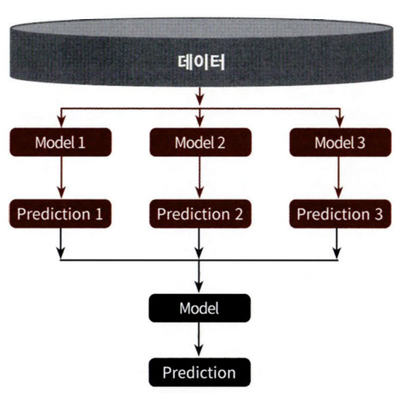

M개의 로우, N개의 피처를 가진 데이터 세트에 스태킹 앙상블 적용 가정

> 학습에 사용할 ML모델이 3개일때 먼저 모델별로 각각 학습시킨 뒤 예측하면 각각 M개의 로우를 가진 1개의 레이블 값 도출, 모델별로 도출된 예측 레이블 값을 다시 합해  새로운 데이터 세트를 만들고 이렇게 스태킹된 데이터 세트에 대해 최종 모델을 적용해 최종 예측을 하는 것이 스태킹 앙상블 모델

###기본 스태킹 모델

In [36]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.2,random_state=0)

In [39]:
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)
#예측할 최종 모델
lr_final=LogisticRegression()

In [40]:
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)



AdaBoostClassifier(n_estimators=100)

In [41]:
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('knn 정확도:{0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test,ada_pred)))

knn 정확도:0.9211
랜덤포레스트 정확도:0.9649
결정 트리 정확도:0.9123
에이다부스트 정확도:0.9737


In [42]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [43]:
lr_final.fit(pred,y_test)#왜 테스트 데이터를...??
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도:0.9737


###CV 세트 기반의 스태킹

CV세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차검증 기반으로 예측된 결과 데이터 세트를 이용

최종 모델 학습 시 테스트 데이터를 사용하면 생기는 과적합 문제 해결을 위해

1. 각 모델별로 원본 학습,테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성
> 개별 모델에서 메타 모델인 2차 모델에서 사용될 학습용 데이터와 테스트용 데이터를 교차 검증을 통해서 생성
* 학습용 데이터를 N개의 폴드로 나눔(3개로 가정)
* 3번의 유사한 반복 작업을 수행하고 마지막 반복에서 개별 모델의 예측값으로 학습 데이터와 테스트 데이터를 생성
  1. 3개의 폴드로 나누고 2개는 학습을 위한 데이터 폴드, 하나는 검증을 위한 데이터 폴드, 두개의 폴드로 나뉜 학습 데이터를 기반으로 개별 모델 학습
  2. 학습된 개별 모델은 검증 폴드 1개의 데이터로 예측하고 결과 저장, 이러한 로직을 세번 반복하면서 학습 데이터와 검증 데이터 세트를 변경해가며 학습 후 예측 결과를 별도로 저장
  3. 2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값 생성, 이러한 로직을 3번 반복하며 이 예측값의 평균으로 최종 결괏값을 생성하고 이를 메타 모델을 위한 데이터세트로 사용
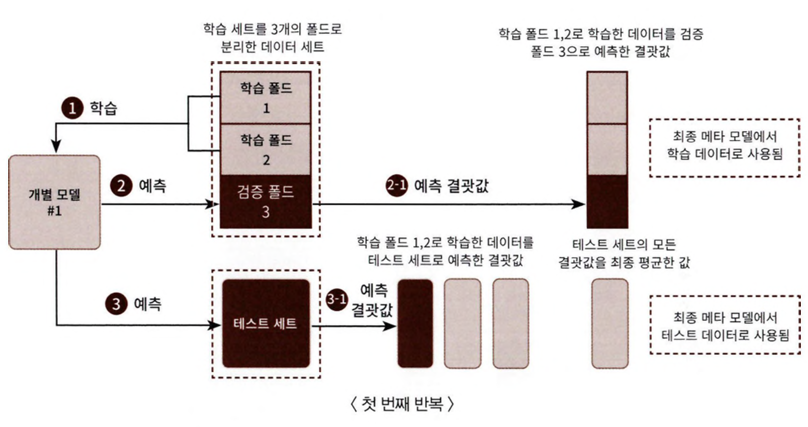

2. 1번에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐 메타 모델이 학습할 최종 학습용 데이터 세트를 생성, 테스트용도 마찬가지, 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤 최종적으로 생성된 테스트 데이터 세트를 예측하고 원본 테스트 데이터의 레이블 데이터를 기반으로 평가


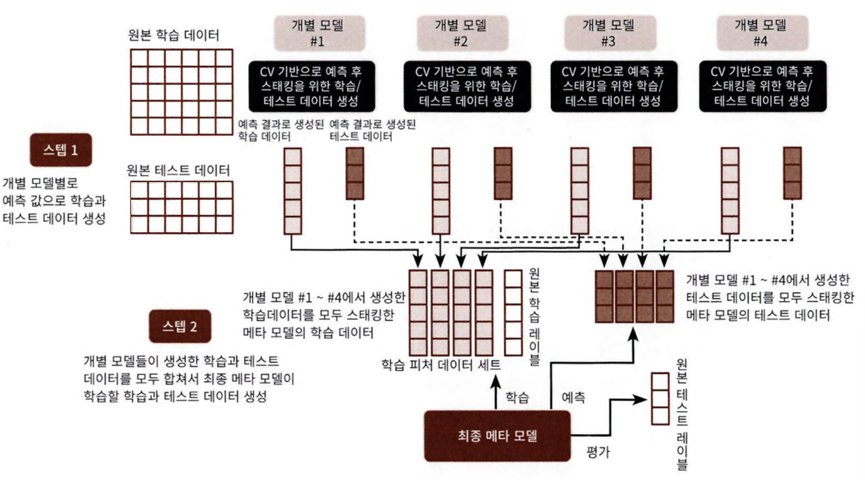

In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  kf=KFold(n_splits=n_folds,shuffle=False)
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model시작')
  for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]
    model.fit(X=X_tr,y=y_tr)

    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter]=model.predict(X_test_n)
  test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)
  return train_fold_pred,test_pred_mean

In [45]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model시작
RandomForestClassifier model시작
DecisionTreeClassifier model시작
AdaBoostClassifier model시작


In [46]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,
      '스태킹 테스트 피처 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 Shape: (114, 4)


In [47]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도:0.9737
